### Preamble

Ok peeking is bad. But let's try to build some intuition around *why* peeking is bad, and what we can do about it.

In [74]:
%matplotlib inline

import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math

### Number of visitors & conversions

Someone arrives on our homepage. They either take a conversion action or they don't. From our past observations we know that roughly 2 of every 100 visitors take a conversion action on our homepage. 

Here's what that might look like:

In [2]:
n_visitors = 100
p_conversion = 2.0 / n_visitors

In [3]:
visitors_100 = np.random.choice([1, 0], size=n_visitors, p=[p_conversion, 1 - p_conversion])
print(visitors_100)
print("\nNumber of conversions: {}".format(visitors_100.sum()))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]

Number of conversions: 2


An easier way to get the number of conversions would be to call the scipy random variables (rvs) method:

In [4]:
stats.binom.rvs(n=n_visitors, p=p_conversion)

1

### Number of experiments

We're responsible statisticians, so we know that we could be getting an abnormally high or low number of conversions in the 100 visitors we're examining due to chance. So let's repeat our "experiment" 10 times.

In [5]:
n_experiments = 10

In [6]:
v100_times_10 = stats.binom.rvs(n=n_visitors, p=p_conversion, size=n_experiments)
print(v100_times_10)
print("\nAverage number of conversions: {}".format(np.mean(v100_times_10)))

[1 2 5 6 3 2 2 3 2 1]

Average number of conversions: 2.7


In [7]:
v100_t10_cnv = v100_times_10 / float(n_visitors)

print(v100_t10_cnv)
print("\nAverage conversion rate: {}".format(np.mean(v100_t10_cnv)))

[ 0.01  0.02  0.05  0.06  0.03  0.02  0.02  0.03  0.02  0.01]

Average conversion rate: 0.027


So we have greater confidence in our estimation of our conversion rate, but we need more traffic to do it.

### Standard error

A standard error calculation gives us the amount of deviation from the average conversion rate we can expect to see if our experiment is repeated multiple times.

In [8]:
def std_error(p, n): return math.sqrt(p * (1 - p) / n)

In [9]:
std_error = std_error(p_conversion, n_visitors)
print(std_error)

0.014


### Building intuition for standard error

How can we think intuitively about our standard error metric? 

We might think of it as "the amount of variation we would expect to see within one standard deviation of our average conversion rate". One standard deviation contains 68% of the outcomes we would expect to see in our data, so 68% of the time our conversion rate should lie between 0.02 - 0.014 = 0.006 and 0.02 + 0.014 = 0.034.

Let's see if our data conforms to this assumption.

In [10]:
lower_se = p_conversion - std_error
upper_se = p_conversion + std_error
print("CNV - Std Error: {}\nCNV + Std Error: {}".format(lower_se, upper_se))

CNV - Std Error: 0.006
CNV + Std Error: 0.034


In [11]:
v100_t10_between_se = ((v100_t10_cnv >= lower_se) & (v100_t10_cnv <= upper_se))
print(v100_t10_between_se)

[ True  True False False  True  True  True  True  True  True]


In [12]:
df_trials = pd.DataFrame({
    "Number of Conversions": v100_times_10,
    "Conversion Rate": v100_t10_cnv,
    "Within Standard Error": [1 if i == True else 0 for i in v100_t10_between_se]
}, index=["Trial {}".format(i + 1) for i in range(n_experiments)])[[
    "Number of Conversions",
    "Conversion Rate",
    "Within Standard Error"
]].T

df_trials

,Trial 1,Trial 2,Trial 3,Trial 4,Trial 5,Trial 6,Trial 7,Trial 8,Trial 9,Trial 10
Number of Conversions,1.00,2.00,5.00,6.00,3.00,2.00,2.00,3.00,2.00,1.00
Conversion Rate,0.01,0.02,0.05,0.06,0.03,0.02,0.02,0.03,0.02,0.01
Within Standard Error,1.00,1.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00


What % of trials ended up with a conversion rate within our standard error range?

In [13]:
pd.DataFrame(
    zip(*np.unique(v100_t10_cnv, return_counts=True)), 
    columns=["Conversion Rate", "Counts"]
)

,Conversion Rate,Counts
0,0.01,2
1,0.02,4
2,0.03,2
3,0.05,1
4,0.06,1


In [14]:
def percent_between(arr, lower, upper):
    return np.sum((arr >= lower) * (arr <= upper)) / float(len(arr))

In [15]:
percent_between(v100_t10_cnv, lower_se, upper_se)

0.80000000000000004

### Visualizing standard error

Let's increase the number of our experiments so we can get a more robust picture.

In [16]:
v100_times_100 = stats.binom.rvs(n=n_visitors, p=p_conversion, size=100)
v100_t100_cnv = v100_times_100 / float(n_visitors)

In [17]:
pd.DataFrame(
    zip(*np.unique(v100_t100_cnv, return_counts=True)),
    columns=["Conversion Rate", "Counts"]
)

,Conversion Rate,Counts
0,0.00,16
1,0.01,26
2,0.02,22
3,0.03,20
4,0.04,11
5,0.05,4
6,0.07,1


In [18]:
percent_between(v100_t100_cnv, lower_se, upper_se)

0.68000000000000005

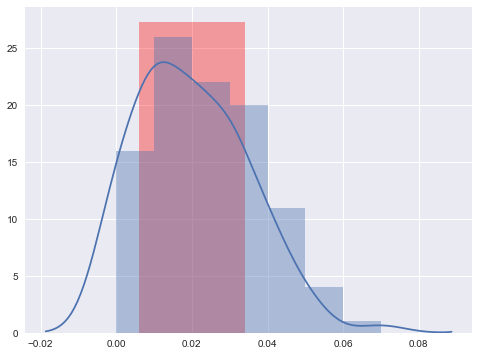

In [61]:
fig, axarr = plt.subplots(figsize=(8, 6))

_ = sns.distplot(
    v100_t100_cnv, 
    bins=len(np.unique(v100_t100_cnv))
)

plt_height = plt.ylim()[1]
_ = plt.fill_between(
    x=np.arange(lower_se, upper_se, 0.001),
    y1=plt_height,
    facecolor="red",
    alpha=0.35
)

# _ = plt.annotate("CNV less std error: {}".format(lower_se), xy=(lower_se + 0.002, 7))
# _ = plt.annotate("CNV plus std error: {}".format(upper_se), xy=(upper_se + 0.002, 22))

### Confidence intervals

The red shaded area represents the space (between our standard error ranges) in which 68% of our observations can be found. 0.006 and 0.034 represent the lower and upper bounds, respectively, of a 68% confidence interval for our data.

What if we want to show the area representing 80% of expected values? What would the lower and upper bounds be for an 80% confidence interval?

In [69]:
s_stdev = np.std(v100_t100_cnv)
s_mean = np.mean(v100_t100_cnv)
s_df = n_visitors - 1

In [70]:
t_critical = stats.t.ppf(q=0.8, df=s_df)
margin_err = t_critical * s_stdev / math.sqrt(n_visitors)
c_interval = (s_mean - margin_err, s_mean + margin_err)
print("80% Confidence Lower Interval: {}\n80% Confidence Upper Interval: {}".format(
    round(c_interval[0], 3), round(c_interval[1], 3)
))

80% Confidence Lower Interval: 0.019
80% Confidence Upper Interval: 0.021


In [71]:
lower_ci = stats.t.ppf(0.1, df=s_df, loc=s_mean, scale=s_stdev)
upper_ci = stats.t.ppf(0.9, df=s_df, loc=s_mean, scale=s_stdev)
print("80% Confidence Lower Interval: {}\n80% Confidence Upper Interval: {}".format(
    round(lower_ci, 3), round(upper_ci, 3)
))

80% Confidence Lower Interval: 0.001
80% Confidence Upper Interval: 0.039


In [72]:
lower_ci, upper_ci = stats.t.interval(alpha=0.8, df=s_df, loc=s_mean, scale=s_stdev)
print("80% Confidence Lower Interval: {}\n80% Confidence Upper Interval: {}".format(
    round(lower_ci, 3), round(upper_ci, 3)
))

80% Confidence Lower Interval: 0.001
80% Confidence Upper Interval: 0.039


In [73]:
percent_between(v100_t100_cnv, lower_ci, upper_ci)

0.68000000000000005

If we look at our plots side by side we can see that the range has indeed increased.

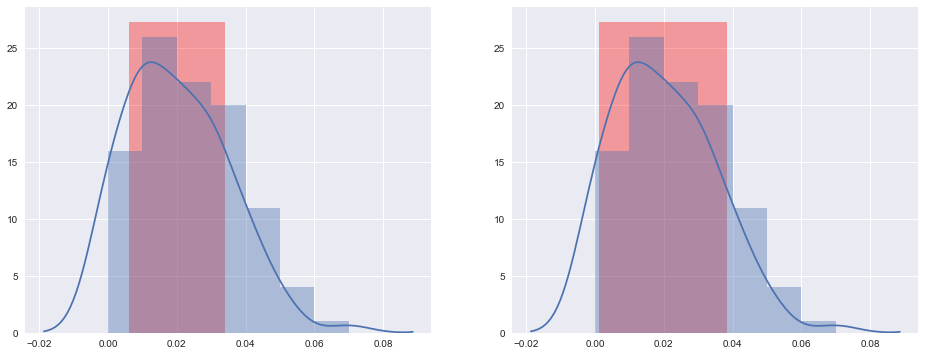

In [23]:
fig, axarr = plt.subplots(1, 2, figsize=(16, 6))

ax1 = axarr[0]
_ = sns.distplot(v100_t100_cnv, bins=len(np.unique(v100_t100_cnv)), ax=ax1)
_ = ax1.fill_between(
    x=np.arange(lower_se, upper_se, 0.001),
    y1=plt_height,
    facecolor="red",
    alpha=0.35
)

ax2 = axarr[1]
_ = sns.distplot(v100_t100_cnv, bins=len(np.unique(v100_t100_cnv)), ax=ax2)
_ = ax2.fill_between(
    x=np.arange(lower_ci, upper_ci, 0.001),
    y1=plt_height,
    facecolor="red",
    alpha=0.35
)

### Simple A/A testing

### The Problem

You have 100 marketers running A/A tests, stopping as soon as they get to p < 0.05 or the test is shown to 10,000 visitors. 

How many of them will stop early? 5? 10? 20? 30?

In [92]:
%%time 

n = 1000
stopped = 0
stop_point = 1.96 * math.sqrt(n)

for i in range(10000):
    d = 0
    for j in range(n):
        d += random.choice([-1, 1])
        if d > stop_point:
            stopped += 1
            break
            
print("Type I Error: {}".format(stopped / 10000.0))

Type I Error: 0.0467
CPU times: user 14.9 s, sys: 162 ms, total: 15.1 s
Wall time: 15.2 s
